In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split # function for splitting data to train and test sets
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('/kaggle/input/twitter-sentiment/Sentiment.csv')
# Keeping only the neccessary columns
df=data.copy()
data = data[['text','sentiment']]

In [3]:
data.head()

,text,sentiment
0,RT @NancyLeeGrahn: How did everyone feel about...,Neutral
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive
2,RT @TJMShow: No mention of Tamir Rice and the ...,Neutral
3,RT @RobGeorge: That Carly Fiorina is trending ...,Positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive


In [4]:
data.shape

(13871, 2)

In [5]:
df['candidate'].nunique()

11

In [6]:
df['sentiment'].value_counts()

Negative    8493
Neutral     3142
Positive    2236
Name: sentiment, dtype: int64

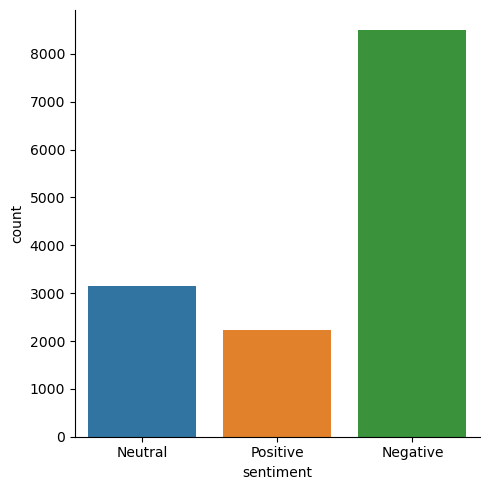

In [7]:
sns.catplot(x='sentiment',data=df,kind='count')

In [8]:
df['tweet_location'].value_counts()

USA                               239
Washington, DC                    128
New York, NY                      120
Texas                              88
New York                           75
                                 ... 
Powell, Ohio                        1
Axminster, Devon                    1
St. Paul, MN                        1
Costa Rica                          1
Baltimore, MD & Washington, DC      1
Name: tweet_location, Length: 4288, dtype: int64

In [9]:
df.describe()

,id,candidate_confidence,relevant_yn_confidence,sentiment_confidence,subject_matter_confidence,retweet_count,tweet_id
count,13871.000000,13871.000000,13871.000000,13871.000000,13871.000000,13871.000000,1.387100e+04
mean,6936.000000,0.855689,0.927304,0.756936,0.782801,45.803331,6.296058e+17
std,4004.357127,0.241388,0.141696,0.217682,0.258215,153.981724,9.611863e+13
min,1.000000,0.222200,0.333300,0.186000,0.222200,0.000000,6.294531e+17
25%,3468.500000,0.674200,1.000000,0.651700,0.641300,0.000000,6.294861e+17
50%,6936.000000,1.000000,1.000000,0.681300,1.000000,2.000000,6.296726e+17
75%,10403.500000,1.000000,1.000000,1.000000,1.000000,44.000000,6.296882e+17
max,13871.000000,1.000000,1.000000,1.000000,1.000000,4965.000000,6.297017e+17


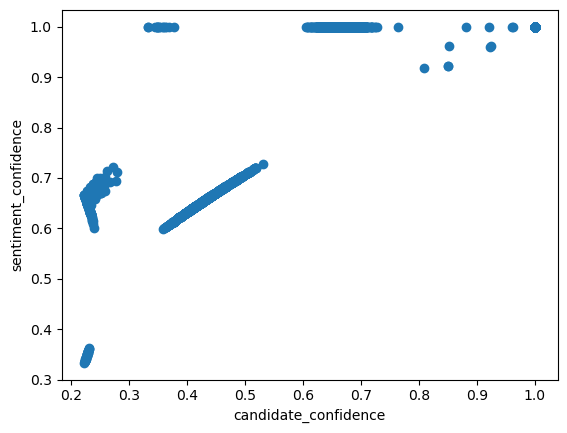

In [10]:
plt.scatter(df['candidate_confidence'],df['relevant_yn_confidence'])
plt.xlabel('candidate_confidence')
plt.ylabel('sentiment_confidence')
plt.show()

In [11]:
# Splitting the dataset into train and test set
train, test = train_test_split(data,test_size = 0.2, shuffle=True, stratify=data.sentiment,random_state=42)

In [12]:
train_pos = train[ train['sentiment'] == 'Positive']
train_pos = train_pos['text']
train_neg = train[ train['sentiment'] == 'Negative']
train_neg = train_neg['text']
train_neutral = train[ train['sentiment'] == 'Neutral']
train_neutral = train_neutral['text']

In [13]:
def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

Neutral words


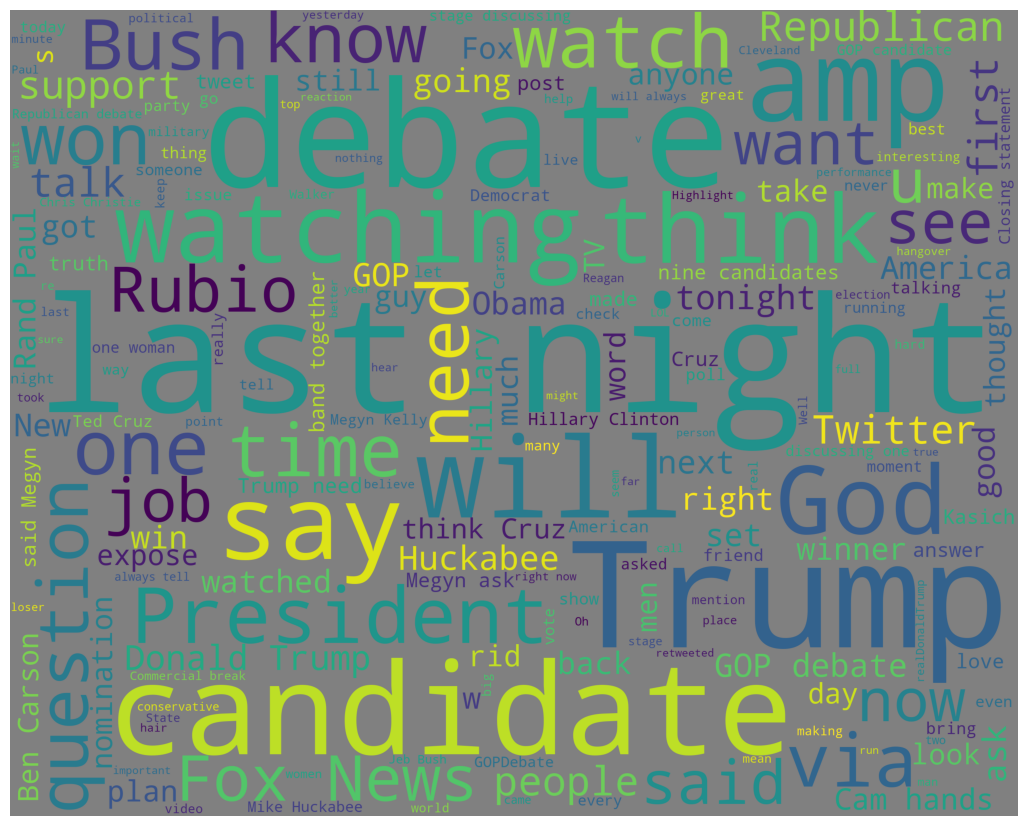

In [14]:
print("Neutral words")
wordcloud_draw(train_neutral,'grey')

Positive words


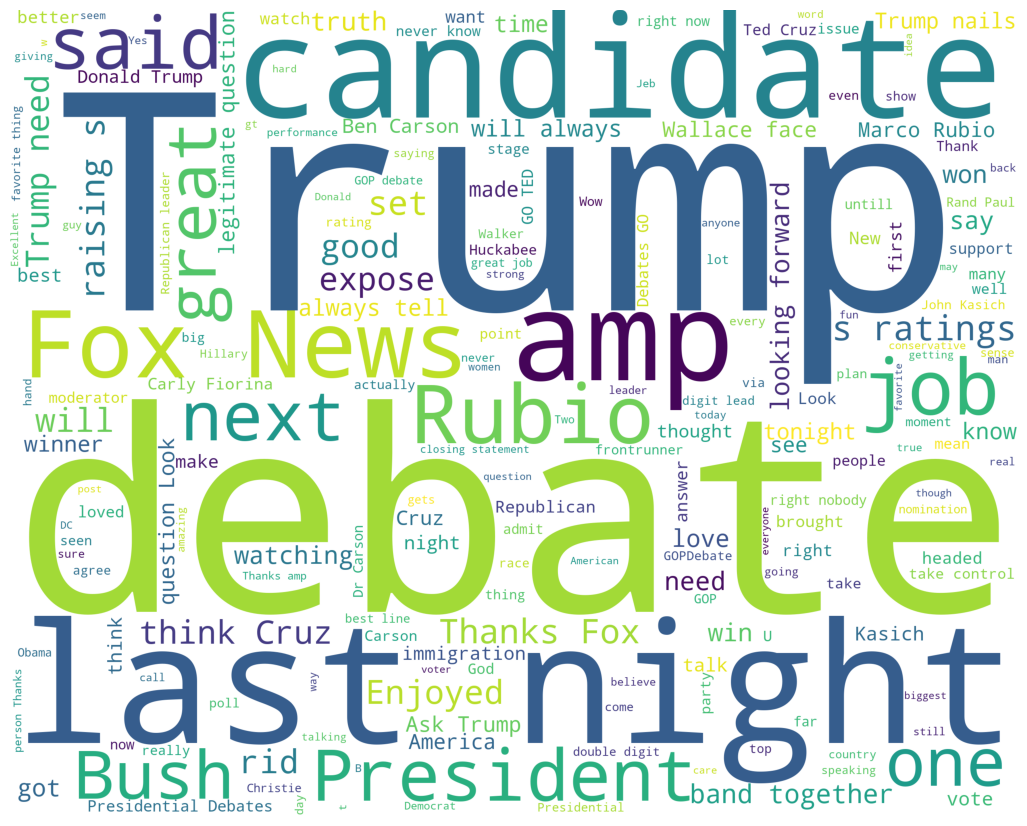

In [15]:
print("Positive words")
wordcloud_draw(train_pos,'white')

Negative words


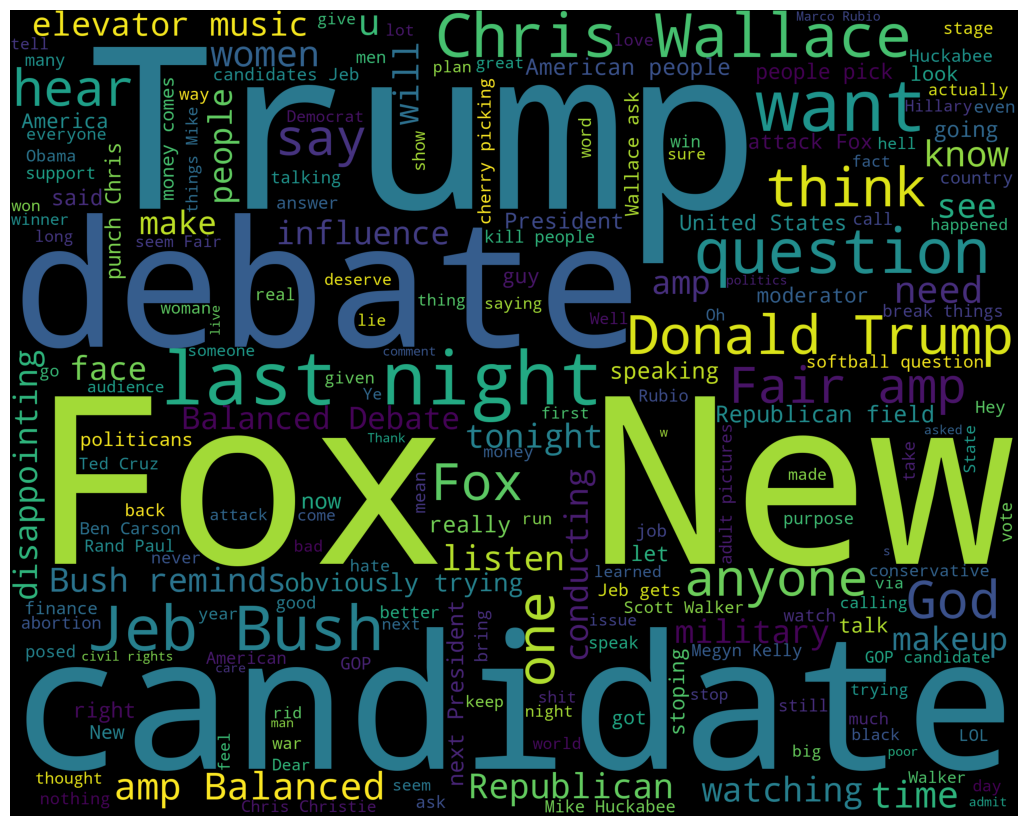

In [16]:
print("Negative words")
wordcloud_draw(train_neg)

In [17]:
tweets = []
stopwords_set = set(stopwords.words("english"))

for index, row in train.iterrows():
    words_filtered = [e.lower() for e in row.text.split() if len(e) >= 3]
    words_cleaned = [word for word in words_filtered
        if 'http' not in word
        and not word.startswith('@')
        and not word.startswith('#')
        and word != 'RT']
    words_without_stopwords = [word for word in words_cleaned if not word in stopwords_set]
    tweets.append((words_without_stopwords, row.sentiment))

test_pos = test[ test['sentiment'] == 'Positive']
test_pos = test_pos['text']
test_neg = test[ test['sentiment'] == 'Negative']
test_neg = test_neg['text']
test_neutral = test[ test['sentiment'] == 'Neutral']
test_neutral = test_neutral['text']

In [18]:
# Extracting word features
def get_words_in_tweets(tweets):
    all = []
    for (words, sentiment) in tweets:
        all.extend(words)
    return all

def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    features = wordlist.keys()
    return features
w_features = get_word_features(get_words_in_tweets(tweets))

def extract_features(document):
    document_words = set(document)
    features = {}
    for word in w_features:
        features['contains(%s)' % word] = (word in document_words)
    return features

In [19]:
# Training the Naive Bayes classifier
training_set = nltk.classify.apply_features(extract_features,tweets)
classifier = nltk.NaiveBayesClassifier.train(training_set)

In [20]:
neg_cnt = 0
pos_cnt = 0
neutral_cnt=0
for obj in test_neg: 
    res =  classifier.classify(extract_features(obj.split()))
    if(res == 'Negative'): 
        neg_cnt = neg_cnt + 1
for obj in test_pos: 
    res =  classifier.classify(extract_features(obj.split()))
    if(res == 'Positive'): 
        pos_cnt = pos_cnt + 1
for obj in test_neutral: 
    res =  classifier.classify(extract_features(obj.split()))
    if(res == 'Neutral'): 
        neutral_cnt = neutral_cnt + 1        
print('[Negative]: %s/%s '  % (len(test_neg),neg_cnt))        
print('[Positive]: %s/%s '  % (len(test_pos),pos_cnt)) 
print('[Neutral]: %s/%s '  % (len(test_neutral),neutral_cnt))  

[Negative]: 1699/1501 
[Positive]: 447/123 
[Neutral]: 629/147 
